# WORKFLOW for the creation of the ML potentials at Constant Potential

Requirements:

- "Franken" => training and testing of the ML potential
- "LAMMPS" => MD
- "DEAL" python suite + "FLARE" => selection of new configurations
- "VASP" (or alternatively a DFT code) => single-point calculations for the labelling of the configurations 
- "DoubleRefernceMethod" python suite => handling of the DFT workflow

Sequence of STEPS:

0. **STEP 0**: Development of a PZC model (alternatively a pre-trained general-purpose model can be employed) => see notebook "Workflow_PZC.ipynb" 
1. **STEP 1**: Training via Transfer Learning
2. **STEP 2**: Explorative MD simulation with LAMMPS
3. **STEP 3**: "DEAL" selection of new configurations
4. **STEP 4**: Single-point calculations for the labelling of the configurations at constant potential

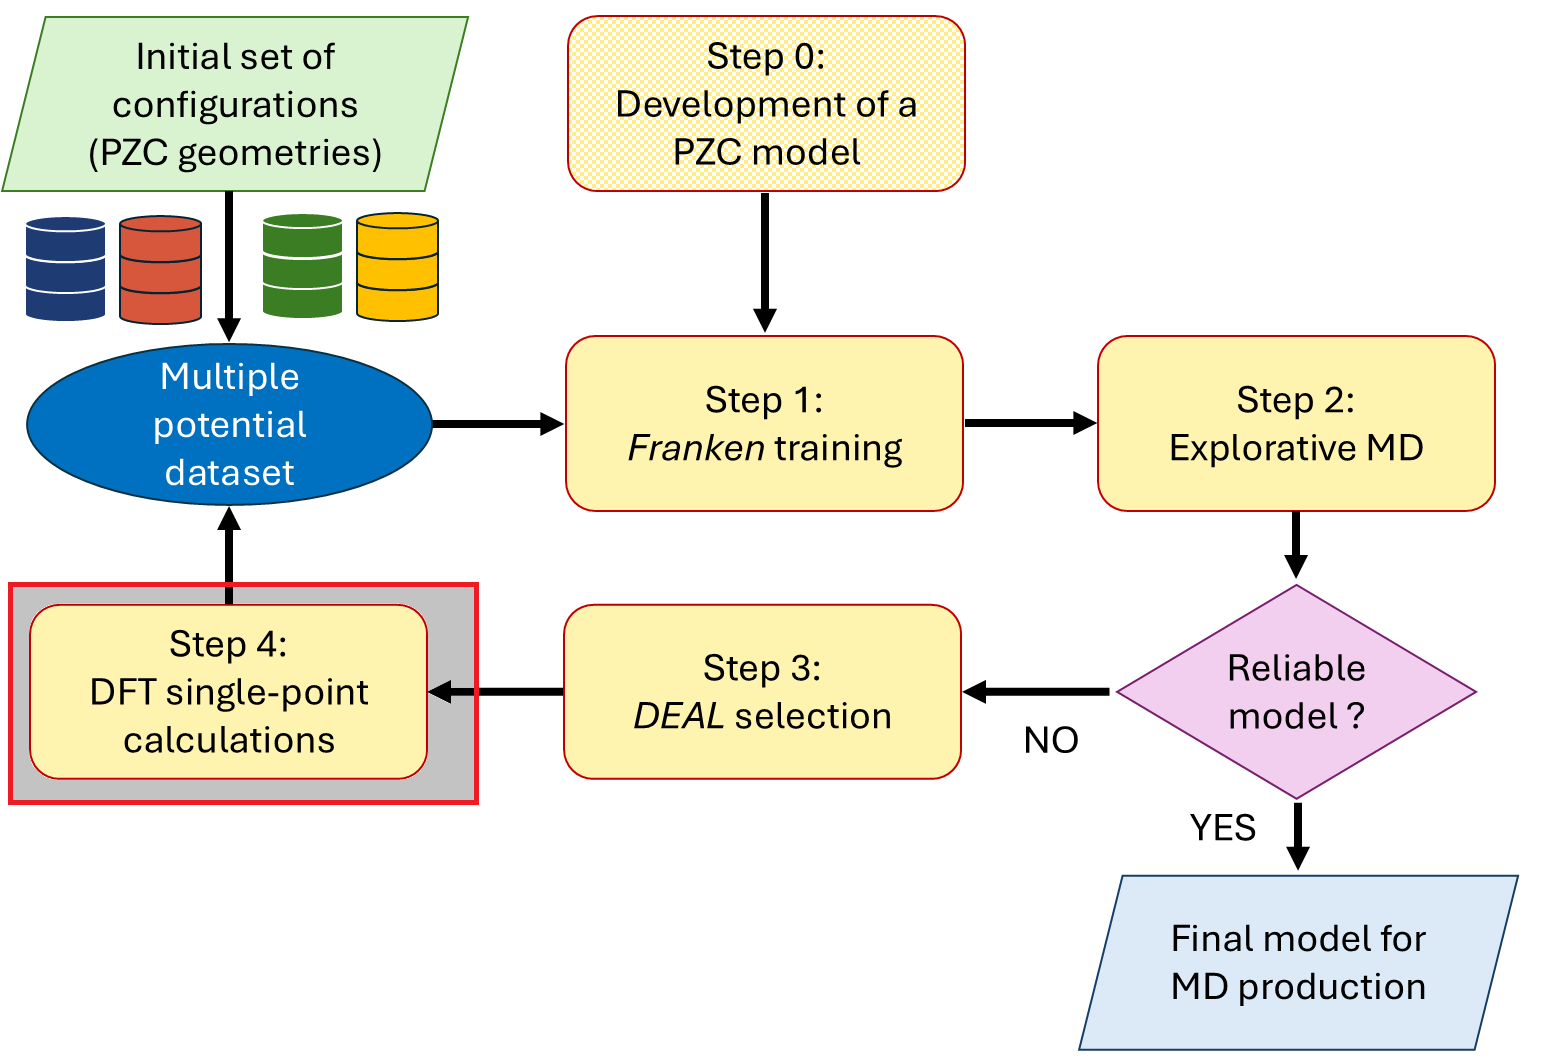

In [1]:
from IPython.display import Image
Image(filename='DFT/CP_workflow_general_step4.png',width=700, height=600)

These steps should be repeated until the generated ML potentials are sufficiently reliable, i.e.:
- they allow for stable MD simulations
- they are accurate
- they grant converged physical properties (e.g., solvent density profile)

Here we focus on **STEP 4**: Single-point calculations for the labelling of the configurations at constant potential

In [2]:
# Imports:
import numpy as np
import sys
import os
import glob
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
from datetime import datetime
from natsort import natsorted

from ase import Atom
from ase.io import read,write

# Path to the workflow_utils directory
# !!! MODIFY IF NEEDED !!!
workflow_utils_path = "../"
sys.path.append(workflow_utils_path)

In [3]:
# SPECIFY the values of target potentials to be used in the calculations
V_vector = [-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0]
V_vector = np.array(V_vector)

print("Target potentials (V vs SHE) to be used in the calculations:\n",V_vector)

from workflow_utils.python_utils import convert_V_to_label

V_vector_labels=convert_V_to_label(V_vector)

print("Corresponding labels for the target potentials:\n",V_vector_labels)

Target potentials (V vs SHE) to be used in the calculations:
 [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
Corresponding labels for the target potentials:
 ['m05', 'm075', 'm1', 'm125', 'm15', 'm175', 'm2']


# STEP 4: Single-point calculations for the labelling of the configurations at constant potential

In [4]:
os.chdir('DFT')

print(natsorted(os.listdir()))

# This directory includes:
# 1) sbatch_vasp_ase => the job submission script to run the VASP single-point calculations via ASE calculator
#                       Check to load the correct module and conda environment and set the correct paths
# 2) DoubleRefernceWorkflow_Const_Pot.py => python script to handle the DFT workflow at constant potential
#                                     Check and customize the DFT parameters in the script
#
# 3) Different folders, each one collecting the single-point calculation for a geometry associated with a specific potential value
#   (e.g., "m05" contains different subfolders "case_0", "case_1" etc..,
#   each subfolders will contain the output of the DFT calculations for the geometries associated with V = -0.5 V vs SHE)
                                 
os.chdir('..')

['DoubleReferenceWorkflow_Const_Pot.py', 'm075', 'm125', 'm175', 'sbatch_vasp_ase_template']


Create the different folders for each configuration

In [ ]:
from workflow_utils.python_utils import create_DFT_scripts

print(f"The applied potential cases are: {V_vector}")
print(f"The associated labels are: {V_vector_labels}\n")

# !!! SPECIFY MANUALLY which set of geometries do you want to compute !!!
#e.g.
case="m175"

# Specify the potential values you want to compute with the "double reference method"
#e.g.
V_to_do=[-1.5,-1.75,-2.0] # i.e. we are considering a geometry that is compatible with V = -0.75 V.
                          # However, we observe that it is useful to label the same geometry not only at the target 
                          # potential (-0.75 V), but also at potentials close to it (-0.50 and -1.0 V). 

# Notice that the high computational cost of the "double reference method" is associated with 
# the auxiliary systems (without extra charge).This implies that labeling the same geometry at different 
# target potentials requires computing the auxiliary system ONCE, allowing the computational cost of the 
# auxiliary systems to be distributed on more constant-potential datasets.



# Specify the initial guesses for the capacitance and the extra electron charge to add to the system 
# associated with the first value of "V_to_do"
EXTRA_ELEC=3 # [e]
C_START=0.008856 # [e/(V A^2)]

# Count of the number of configurations for the selected case
counter_configuration=len([f for f in os.listdir(f"DEAL/POSCAR_temp/{case}")])

help(create_DFT_scripts)

The applied potential cases are: [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
The associated labels are: ['m05', 'm075', 'm1', 'm125', 'm15', 'm175', 'm2']

Help on function create_DFT_scripts in module workflow_utils.python_utils:

create_DFT_scripts(
    num_configurations,
    case,
    template_script,
    path_poscar,
    python_calc_file,
    customize_potential,
    V_case=None,
    extra_elec=None,
    C_guess=None
)
    This script creates the sbatch scripts for the DFT single-points.
    The sbatch scripts are saved in folders "case_0', 'case_1' etc...

    Inputs:
        - num_configurations: int, number of configurations to label
        - case: string, it identifies the case (e.g., "PZC", "m05" etc...)
        - template_script: string, name of the template script (default: sbatch_vasp_ase_template)
        - path_poscar: string, path to the POSCAR files for the DFT single-points
        - python_calc_file: string, path to the python file containing the VASP calculator
   

In [ ]:
os.chdir('DFT')

create_DFT_scripts(
                    num_configurations=counter_configuration,
                    case=case,
                    template_script='sbatch_vasp_ase_template',# Verify the settings in this template for the sbatch script
                    path_poscar=f'../../../DEAL/POSCAR_temp/{case}', 
                    python_calc_file=f'DoubleReferenceWorkflow_Const_Pot.py',
                    customize_potential=True,
                    V_case=V_to_do,
                    extra_elec=EXTRA_ELEC,
                    C_guess=C_START
                    )

os.chdir('..')

Run the DFT calculations with the Double Reference Workflow

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

os.chdir(f'DFT/{case}')

# In this tuttorial, we performed the DFT calculation only for few configurations
#counter_configuration=2

for i in range(0,counter_configuration):
    print(f"Potential case {case}: geometry number {i}")
    os.chdir(f'case_{i}')
    os.system(f"sbatch sbatch_vasp_ase")
    os.chdir('../')

os.chdir('../../')

Potential case m175: submitting case number 0
Submitted batch job 21200290
Potential case m175: submitting case number 1
Submitted batch job 21200291


Check the results of the Double Reference Workflow

In [ ]:
# Check that all the workflows ended smoothly

# !!! SPECIFY MANUALLY which set of geometries do you want to compute !!!
#e.g.
case="m175"

file_paths = glob.glob(f"DFT/{case}/case_*/case_*/*")

print("Check workflow ends smoothly:\n")

for file in natsorted(file_paths):
    
    #print(file)
    
    # Search if run folders have been removed => If run folders still present, the workflow was interrupted prematurely
    # (e.g., submission time limit)
    if file.endswith("/neutral") is True or file.endswith("/neutral_vacuum") is True or file.endswith("/charge") is True:

        print(f"Workflow does not end smoothly in {file}. Check it !\n") 
                   
print("Done")

Check workflow ends smoothly:

Done


In [11]:
# Check that all the calculations reached convergence

file_paths = glob.glob(f"DFT/{case}/case_*/case_*/OUTCAR_*")

print("Check DFT convergence:\n")

# Search for lines containing both 'aborting' and 'unconverged'
# When VASP does not converge, it prints a line like:
# "aborting loop EDIFF was not reached (unconverged)"

for file in file_paths:
    
    # Look only for VASP files not for xyz files
    if file.endswith("xyz") is False:
        
        # Flag to check if Vasp ended smoothly
        end=False
        with open(file, 'r') as file:
            for line_num, line in enumerate(file, start=1):
                if 'aborting' in line: # VASP ends smoothly
                    end=True
                    if 'aborting' in line and 'unconverged' in line: # VASP did not converge
                        print(f"VASP did not converge in {file}. Check it !\n") 
                    #else: # Vasp converged, so do nothing
                    
        if end is False: # Not found 'aborting' string => VASP did not finish smoothly, check what happened
            print(f"VASP did not finish smoothly in {file}:. Check it !\n")

print("Done")

Check DFT convergence:

Done


In [12]:
# Check the FCP routine reached the target potential within a fixed number of iterations (e.g. 20)
# See parameter max_FCP_iter in function DoubleReferenceWorkflow() in ase.calculators.DoubleReferenceMethod.DoubleReferenceWorkflow_calc.py

max_FCP_iter=20

file_paths = glob.glob(f'DFT/{case}/case_*/case_*/log-fcp_U_*')

print("Check FCP convergence:\n")

# Check second line of log-fcp_U_*.txt file where the first number is the number of performed loop in the FCP
for path in natsorted(file_paths):
    
    with open(path, 'r') as file:
        content = file.readlines()

    try:
        line=content[1]
        
        line_element=line.split()
        
        step=int(line_element[0])
       
        if step==max_FCP_iter:
            print(f"FCP did not converge in {path}. Check it !\n")
            

    except Exception as e: # Nothing found in log-fcp_U_*.txt => FCP did not finish smoothly, check what happened
        print(f"FCP did not finish smoothly in {path}\n")

print("Done")


Check FCP convergence:

Done


Extract info from the DFT output files to generate the dataset files

In [4]:
# Collect energy, forces, Bader charges etc... from the different configurations in a single ext-xyz file.
# The ext-xyz file will be moved to the dataset folder for the next active learning cycle

# !!! SPECIFY MANUALLY which set of geometries do you want to compute !!!
#e.g.
case="m175"

# Specify the potential values you want to compute with the "double reference method"
#e.g.
V_to_do=[-1.5,-1.75,-2.0]

from workflow_utils.python_utils import extract_data_from_multiple_potential_dataset

help(extract_data_from_multiple_potential_dataset)

Help on function extract_data_from_multiple_potential_dataset in module workflow_utils.python_utils:

extract_data_from_multiple_potential_dataset(
    case,
    V_to_do,
    round,
    folder_input,
    custom_output_file,
    folder_output
)
    Function extracting the data from the different folders (case_xx) generated by the DFT,
    separating the info of the different target potentials and moving xyz files in the dataset
    folders for the next round of active learning

    Inputs:
        - case: str, label identify the potential value folder of the DFT calculations
        - V_to_do: array, values of the target potential for which one wants to extract the data
        - round: int, number identifying the current round of active learning
        - folder_input: str, path of the folder where there are the DFT results
        - custom_output_file: str, attribute to add to the name of the xyz file
        - folder_output: str, path of the folder where the xyz will be saved



In [6]:
extract_data_from_multiple_potential_dataset(
                                            case=case,
                                            V_to_do=V_to_do,round=0,
                                            folder_input=f'DFT/{case}/',
                                            custom_output_file="Cu111_H2O",
                                            folder_output=f'Training/Dataset/'
                                            )

print("Done !")

Extract data for V = -1.5 V
Number of configurations  for m15: 2
Extract data for V = -1.75 V
Number of configurations  for m175: 2
Extract data for V = -2.0 V
Number of configurations  for m2: 2
Extract data for PZC
Number of configurations for PZC: 2

Done !


/leonardo_work/IscrB_HERMAN/michele_b/code_v_17_11/DoubleReference-MLFF/Constant_potential/../workflow_utils/python_utils.py:702: FutureWarning: Please use atoms.calc
  calculator=snap_charge.get_calculator(),
/leonardo_work/IscrB_HERMAN/michele_b/code_v_17_11/DoubleReference-MLFF/Constant_potential/../workflow_utils/python_utils.py:734: FutureWarning: Please use atoms.calc
  calculator=snap_charge.get_calculator(),


Ready to start a new round of active learning !